In [221]:
import random
import math
from tqdm import tqdm_notebook
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#make pyplot text blue
params = {"ytick.color" : "r",
          "xtick.color" : "r",
          "axes.labelcolor" : "r",
          "axes.edgecolor" : "r"}
plt.rcParams.update(params)

In [222]:
#A few helper functions representing a common activation function and its derivative
def sigmoid(x):
    return 1/(1 + math.exp(-x))

def sigmoid_derivative(s):
    return s * (1.0 - s)

In [223]:
"""#Takes the rate of 'loss' of a line, it's current value, and its input and finds an approx of the slope
def leaky_integrator(A, x, C):
    return (-A) * x + C

#Returns an approximation of the value of a lone after time "time_step"
def forward_euler_method(time_step, slope, value):
    return value + time_step * slope"""

class ContinuousNeuron(object):
    def __init__(self, weights=[], bias=0, tau=1, index=0): #, gain=1):
        self.weights = weights
        self.bias = bias
        self.tau = tau
        self.input = 0
        self.state = 0
        self.output = 0.0
        self.index = index
        
    @property
    def tau(self):
        return self.__tau
    
    @tau.setter
    def tau(self, x):
        self.__tau = x
        self.leak_rate = 1 / self.__tau
        
    def get_output(self, neuron_outputs, step_size):
        #input from previous neurons
        input_sum = sum([neuron_outputs[i] * self.weights[i] for i in range(len(self.weights))])
        input_sum += self.input
        
        self.state += step_size * self.leak_rate * ((-self.state) + input_sum)
        self.output = sigmoid(self.state + self.bias)
        return self.output

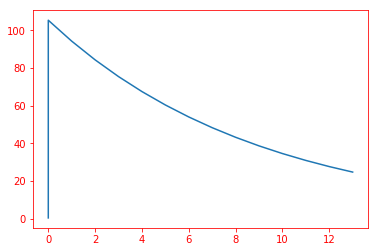

In [224]:
neuron = ContinuousNeuron([0.0], tau=9.5, index=0)

x = []
y = []

#Make graph look better
x.append(0)
y.append(neuron.get_output([0.0], 1))

neuron.input = 1000 #Set external input before getting output, for an initial input

for i in range(0, 14):
    neuron.get_output([0.0], 1)
    x.append(i)
    y.append(neuron.state)
    
    #Set the input back to 0, so that the initial input is the only input
    neuron.input = 0
    
plt.plot(x,y)

In [225]:
class FullyConnectedCTRNN(object):
    def __init__(self, weights, biases, taus):
        self.neurons = [ContinuousNeuron(weights[i], biases[i], taus[i], i) for i in range(len(weights))]
        
    def euler_step(self, time_step): ##TESTED
        #get output of all neurons for previous time step
        #this even contains the output of the neuron that it's being fed into
        prev_outputs = [neuron.output for neuron in self.neurons]
        #use previous layer outputs to compute the current layers
        outputs = [neuron.get_output(prev_outputs, time_step) for neuron in self.neurons]
        
        """for neuron in self.neurons:
            sum_input = neuron.input
            for i in range(len(neuron.weights)):
                sum_input += neuron.weights[i] * self.neurons[i].output
            neuron.state += time_step * neuron.leak_rate * (sum_input - neuron.state)
        
        for neuron in self.neurons:
            neuron.output = sigmoid(neuron.state + neuron.bias)"""
            
                
    
    def randomize_state(self, minimum, maximum):
        #Set the state of neuron
        for neuron in self.neurons:
            neuron.state = random.uniform(minimum, maximum) 
            neuron.output = (neuron.state + neuron.bias)

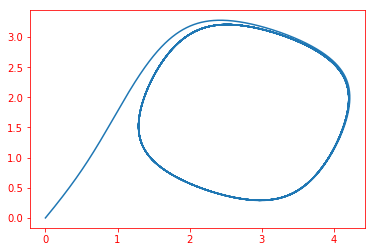

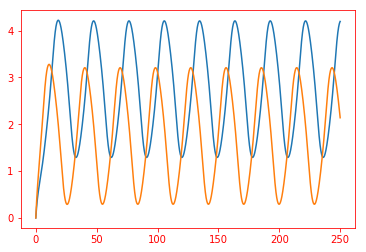

In [230]:
"""
c.SetConnectionWeight(1, 1, 4.5);
c.SetConnectionWeight(1, 2, -1);
c.SetConnectionWeight(2, 1, 1);
c.SetConnectionWeight(2, 2, 4.5);
          1->1 2->1   1->2 2->2
weights = [[4.5, 1], [-1, 4.5]]
"""
### Figure 1lc

#weight list need to be long enough to hold every neuron even self recurrent
weights = [[4.5, 1], [-1, 4.5]]
biases = [-2.75, -1.75]
network = FullyConnectedCTRNN(weights, biases, [1, 1])

x = []
y_1 = []
y_2 = []

time = 0
time_step = 0.01
while time <= 250:
    network.euler_step(time_step)
    x.append(time)
    y_1.append(network.neurons[0].state)
    y_2.append(network.neurons[1].state)
    time += time_step

#plots 2 dimensions of the activation of the 
plt.plot(y_1, y_2)
plt.show()

#plots the activation against the time
plt.plot(x, y_1)
plt.plot(x, y_2)
plt.show()

In [ ]:
#weight list need to be long enough to hold every neuron even self recurrent
weights = [[3, 1], [-1, 3]]
biases = [-2, -1]

statesX = [0.5, 1.5, 2.5]
statesY = [0.5, 1.5, 2.5]
for xState in statesX:
    for yState in statesY:
        network = FullyConnectedCTRNN(weights, biases, [1, 1])
        network.neurons[0].state = xState
        network.neurons[1].state = yState

        x = []
        y_1 = []
        y_2 = []


        time = 0
        time_step = 0.01
        while time <= 500:
            network.euler_step(time_step)
            x.append(time)
            y_1.append(network.neurons[0].state)
            y_2.append(network.neurons[1].state)
            time += time_step

        #plots 2 dimensions of the activation of the 
        plt.plot(y_1, y_2)

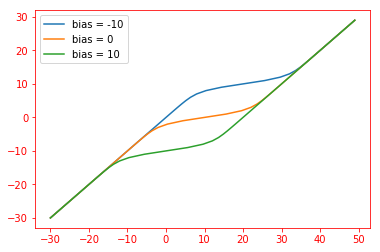

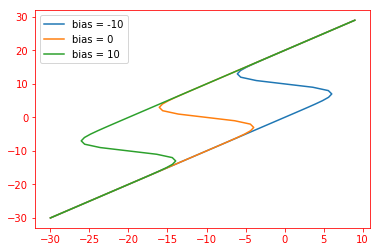

In [227]:
#pg 473 - first image
def I(y, w, bias):
    return y - w * sigmoid(y + bias)

for bias in [-10, 0, 10]:
    x = []
    y = []
    for y_o in range(-30, 30, 1):
        x.append(I(y_o, -20, bias))
        y.append(y_o)
    plt.plot(x, y, label="bias = "+str(bias))
    plt.legend()
plt.show()
    
#pg 473 - second image
for bias in [-10, 0, 10]:
    x = []
    y = []
    for y_o in range(-30, 30, 1):
        x.append(I(y_o, 20, bias))
        y.append(y_o)
    plt.plot(x, y, label="bias = "+str(bias))
    plt.legend()
plt.show()
    
###
#This shows that individual neurons are working alright??
###

In [228]:
#w_ji connections
#i is the current neuron
#j is the other neuron